Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
# Split train data in to a train and validation set
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                              stratify=train['status_group'], random_state=42)

In [4]:
import numpy as np

def wrangle(X):
  
  X = X.copy()
  
  # Replace values near zero and outside of Tanzania with zeros
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # Replace zeros in columns where they should be null vales for processing later
  cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population', 'amount_tsh']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
    X[col+'_Missing'] = X[col].isnull()

  # Drop columns that are duplicative
  duplicates = ['quantity_group', 
                  'extraction_type_group', 
                'extraction_type_class', 
                  'payment', 'quality_group']
  X = X.drop(columns = duplicates)

  # Drop columns with zero variance or always varies
  unusable_variance = ['recorded_by', 'id']
  X = X.drop(columns=unusable_variance)

  # Convert date_recorded to datetime
  #Extract day, month, and year then drop date_recorded column
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=False)
  X['day_recorded'] = X['date_recorded'].dt.day
  X['month_recorded'] = X['date_recorded'].dt.month
  X['year_recorded'] = X['date_recorded'].dt.year
  X = X.drop(columns='date_recorded')

  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_Missing'] = X['years'].isnull()

  # Return wrangled dataframe
  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [5]:
target = 'status_group'
features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [6]:
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier


pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(class_weight='balanced_subsample',
                           max_depth=50,
                           max_features=0.22,
                           min_samples_leaf=1,
                           n_estimators=373,
                           random_state=42)
)
# Fit on train, score on val 
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

y_pred = pipeline.predict(X_val)

Validation Accuracy 0.8111952861952862


In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_val, y_pred), columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

print(confusion_matrix(y_val, y_pred))
plot_confusion_matrix(y_val, y_pred);

[[5876  100  476]
 [ 512  215  136]
 [ 971   48 3546]]


In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6452
functional needs repair       0.59      0.25      0.35       863
         non functional       0.85      0.78      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.75      0.65      0.67     11880
           weighted avg       0.80      0.81      0.80     11880



In [9]:
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

False    0.543077
True     0.456923
Name: status_group, dtype: float64

In [10]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

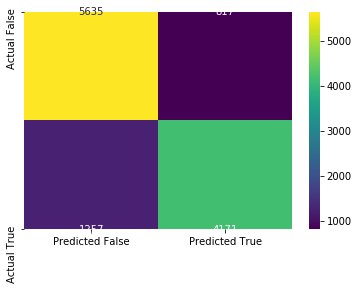

In [11]:
plot_confusion_matrix(y_val, y_pred);